In [1]:
# library import
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import warnings


In [2]:
# read the three data sets
train = pd.read_csv("A2-Data_files/TMDB_train.csv")
evaluate = pd.read_csv("A2-Data_files/TMDB_evaluate.csv")
test = pd.read_csv("A2-Data_files/TMDB_test.csv")

def process_year(year):
    if pd.isna(year):
        return 'unknown'
    if isinstance(year, str) and len(year) == 4 and year.isdigit():
        return int(year)
    match = re.match(r'(\d{4})-\d{2}-\d{2}', str(year))
    if match:
        return int(match.group(1))
    try:
        return pd.to_datetime(year, format='%d/%m/%Y').year
    except:
        return 'unknown'

unlabelled = pd.read_csv("A2-Data_files/TMDB_unlabelled.csv", low_memory=False)
unlabelled['release_year'] = unlabelled['release_year'].apply(process_year)

In [ ]:
# since some languages may not exist across three data sets, concatenate all the original_language columns
from sklearn.preprocessing import LabelEncoder
all_languages = pd.concat([train["original_language"], unlabelled["original_language"], evaluate["original_language"], test["original_language"]])
# all_languages = all_languages.fillna('unknown')
label_encoder = LabelEncoder()
label_encoder.fit(all_languages)
train['original_language'] = label_encoder.transform(train['original_language'])
unlabelled['original_language'] = label_encoder.transform(unlabelled['original_language'])
evaluate['original_language'] = label_encoder.transform(evaluate['original_language'])
test['original_language'] = label_encoder.transform(test['original_language'])

# Excluded Features: ['product_of_India', 'product_of_Japan']
important_features = ['release_year', 'runtime', 'budget', 'revenue', 'adult', 
                      'original_language', 'popularity', 'genre_Action', 'genre_Adventure', 
                      'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 
                      'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 
                      'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 
                      'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 
                      'genre_War', 'genre_Western', 'product_of_Canada', 'product_of_France', 
                      'product_of_Germany', 'product_of_India', 'product_of_Italy', 
                      'product_of_Japan', 'product_of_Spain', 'product_of_UK', 'product_of_USA', 
                      'product_of_other_countries', 'vote_count']

X_train = train[important_features]
y_train = train['rate_category']

X_unlabelled = unlabelled[important_features]
print(X_unlabelled.shape)

X_evaluate = evaluate[important_features]
y_evaluate = evaluate['rate_category']

X_test = test[important_features]


In [56]:
# concatenate labelled and unlabelled data for training
# this block uses varying amount of labelled data combined with all unlabelled data for training
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import SelfTrainingClassifier
intervals = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
np.random.seed(90049)

X_labelled = [X_train]
X_mixed = [pd.concat([X_train, X_unlabelled], ignore_index=True)]
y_labelled = [y_train]
y_mixed = [pd.concat([y_train, pd.Series([-1] * len(X_unlabelled))], ignore_index=True)]

for i in range(1,len(intervals)):
    X_labelled_subset, _, y_labelled_subset, _ = train_test_split(X_train, y_train, train_size=intervals[i], random_state=90049)
    # print(X_labelled_subset.shape)
    X_labelled.append(X_labelled_subset)
    X_mixed.append(pd.concat([X_labelled_subset, X_unlabelled], ignore_index=True))
    y_labelled.append(y_labelled_subset)
    y_mixed.append(pd.concat([y_labelled_subset, pd.Series([-1] * len(X_unlabelled))], ignore_index=True))

dt_labelled_accuracy =[]
knn_labelled_accuracy = []
mlp_labelled_accuracy = []
rf_labelled_accuracy = []
dt_mixed_accuracy =[]
knn_mixed_accuracy = []
mlp_mixed_accuracy = []
rf_mixed_accuracy = []

In [57]:
# compare performance of dt with different amount of labelled data, and after introducing unlabelled data
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=90049)
for i in range(len(intervals)):
    dt.fit(X_labelled[i], y_labelled[i])
    acc1 = dt.score(X_evaluate, y_evaluate)
    acc1 = np.array(acc1)
    dt_labelled_accuracy.append(acc1.round(5))
    self_train_model = SelfTrainingClassifier(dt, criterion='k_best', k_best=3000)
    self_train_model.fit(X_mixed[i], y_mixed[i])
    acc2 = self_train_model.score(X_evaluate, y_evaluate)
    acc2 = np.array(acc2)
    dt_mixed_accuracy.append(acc2.round(5))
print("label:", ["{:.5f}".format(x) for x in dt_labelled_accuracy])
print("mixed:", ["{:.5f}".format(x) for x in dt_mixed_accuracy])


label: ['0.65690', '0.48320', '0.36825', '0.32790', '0.29825', '0.28145', '0.27715']
mixed: ['0.65655', '0.48350', '0.36770', '0.32075', '0.28900', '0.26765', '0.25410']


In [58]:
# compare performance of knn with different amount of labelled data, and after introducing unlabelled data
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
for i in range(len(intervals)):
    knn.fit(X_labelled[i], y_labelled[i])
    acc1 = knn.score(X_evaluate, y_evaluate)
    acc1 = np.array(acc1)
    knn_labelled_accuracy.append(acc1.round(5))
    self_train_model = SelfTrainingClassifier(knn, criterion='k_best', k_best=3000)
    self_train_model.fit(X_mixed[i], y_mixed[i])
    acc2 = self_train_model.score(X_evaluate, y_evaluate)
    acc2 = np.array(acc2)
    knn_mixed_accuracy.append(acc2.round(5))
print("label:", ["{:.5f}".format(x) for x in knn_labelled_accuracy])
print("mixed:", ["{:.5f}".format(x) for x in knn_mixed_accuracy])

label: ['0.41795', '0.35750', '0.31260', '0.29210', '0.27420', '0.26380', '0.26485']
mixed: ['0.41755', '0.35800', '0.31340', '0.28995', '0.27680', '0.26610', '0.26630']


In [59]:
# compare performance of mlp with different amount of labelled data, and after introducing unlabelled data
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=90049, max_iter=200)
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
for i in range(len(intervals)):
    mlp.fit(X_labelled[i], y_labelled[i])
    acc1 = mlp.score(X_evaluate, y_evaluate)
    acc1 = np.array(acc1)
    mlp_labelled_accuracy.append(acc1.round(5))
    self_train_model = SelfTrainingClassifier(mlp, criterion='k_best', k_best=3000)
    self_train_model.fit(X_mixed[i], y_mixed[i])
    acc2 = self_train_model.score(X_evaluate, y_evaluate)
    acc2 = np.array(acc2)
    mlp_mixed_accuracy.append(acc2.round(5))
print("label:", ["{:.5f}".format(x) for x in mlp_labelled_accuracy])
print("mixed:", ["{:.5f}".format(x) for x in mlp_mixed_accuracy])

label: ['0.33830', '0.26805', '0.26140', '0.27520', '0.25575', '0.17150', '0.24400']
mixed: ['0.34315', '0.27095', '0.23125', '0.18175', '0.20410', '0.19245', '0.17080']


In [60]:
# compare performance of rf with different amount of labelled data, and after introducing unlabelled data
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=90049)
for i in range(len(intervals)):
    rf.fit(X_labelled[i], y_labelled[i])
    acc1 = rf.score(X_evaluate, y_evaluate)
    acc1 = np.array(acc1)
    rf_labelled_accuracy.append(acc1.round(5))
    self_train_model = SelfTrainingClassifier(rf, criterion='k_best', k_best=3000)
    self_train_model.fit(X_mixed[i], y_mixed[i])
    acc2 = self_train_model.score(X_evaluate, y_evaluate)
    acc2 = np.array(acc2)
    rf_mixed_accuracy.append(acc2.round(5))
print("label:", ["{:.5f}".format(x) for x in rf_labelled_accuracy])
print("mixed:", ["{:.5f}".format(x) for x in rf_mixed_accuracy])

label: ['0.69130', '0.53495', '0.43050', '0.38800', '0.35935', '0.33050', '0.32295']
mixed: ['0.68965', '0.53310', '0.42720', '0.38895', '0.35350', '0.32680', '0.31285']


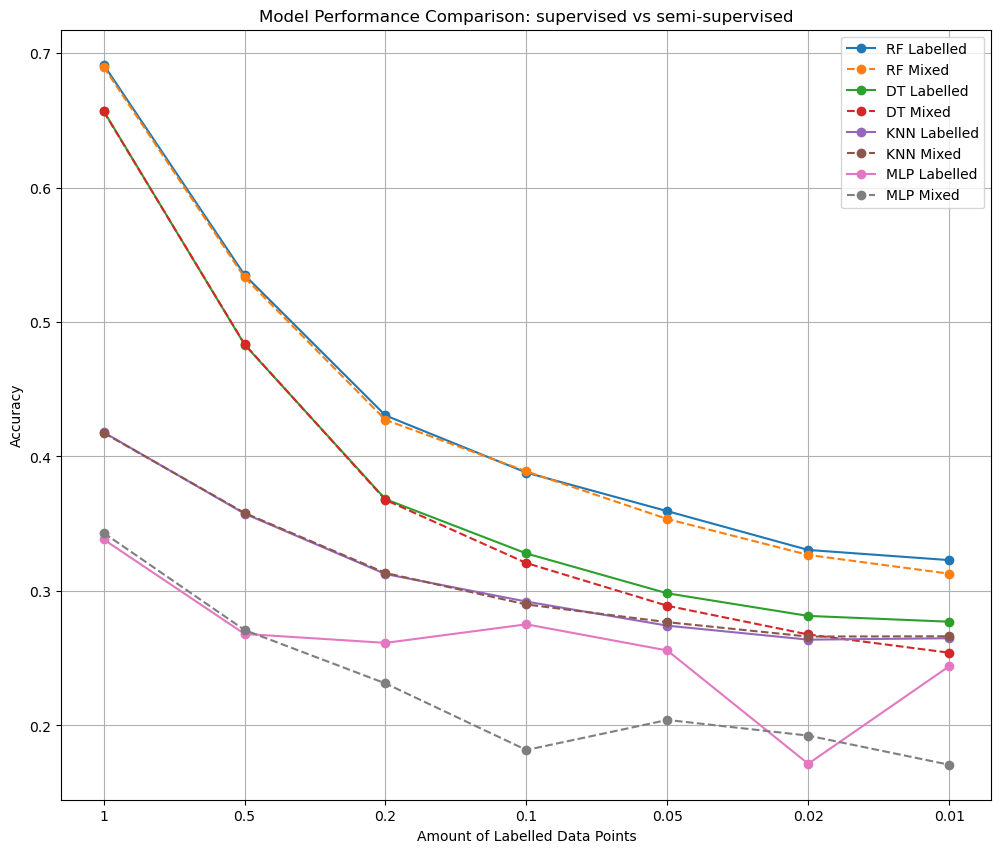

In [80]:
# visualization

plt.figure(figsize=(12, 10))

space = [7,6,5,4,3,2,1]

plt.plot(space, rf_labelled_accuracy, marker='o', linestyle='-', label='RF Labelled')
plt.plot(space, rf_mixed_accuracy, marker='o', linestyle='--', label='RF Mixed')
plt.plot(space, dt_labelled_accuracy, marker='o', linestyle='-', label='DT Labelled')
plt.plot(space, dt_mixed_accuracy, marker='o', linestyle='--', label='DT Mixed')
plt.plot(space, knn_labelled_accuracy, marker='o', linestyle='-', label='KNN Labelled')
plt.plot(space, knn_mixed_accuracy, marker='o', linestyle='--', label='KNN Mixed')
plt.plot(space, mlp_labelled_accuracy, marker='o', linestyle='-', label='MLP Labelled')
plt.plot(space, mlp_mixed_accuracy, marker='o', linestyle='--', label='MLP Mixed')

plt.title('Model Performance Comparison: supervised vs semi-supervised')
plt.xlabel('Amount of Labelled Data Points')
plt.ylabel('Accuracy')

plt.xticks(space, labels=[str(interval) for interval in intervals])

plt.gca().invert_xaxis()

plt.legend()
plt.grid(True)

plt.show()

In [88]:
# use all labelled data, combined with varying amount of unlabelled data to do self training
unlabelled_intervals = [0.01,0.05,0.1,0.2,0.5]
np.random.seed(90049)

X_unlabelled_split = []
X_mixed_split = []
y_mixed_split = []

for i in unlabelled_intervals:
    num_samples = int(X_unlabelled.shape[0] * i)

    indices = np.random.choice(X_unlabelled.shape[0], num_samples, replace=False)

    subset = X_unlabelled.iloc[indices]
    X_unlabelled_split.append(subset)

    X_mixed_split.append(pd.concat([X_train, subset], ignore_index=True))
    y_mixed_split.append(pd.concat([y_train, pd.Series([-1] * len(subset))], ignore_index=True))

for i in range(len(X_unlabelled_split)):
    print(X_unlabelled_split[i].shape, X_mixed_split[i].shape, y_mixed_split[i].shape)

(2547, 37) (102547, 37) (102547,)
(12735, 37) (112735, 37) (112735,)
(25470, 37) (125470, 37) (125470,)
(50940, 37) (150940, 37) (150940,)
(127350, 37) (227350, 37) (227350,)


In [ ]:
dt_semi_accuracy = []
knn_semi_accuracy = []
mlp_semi_accuracy = []
rf_semi_accuracy = []

In [90]:
# decision tree using various amount of unlabelled data
print("original labelled accuracy:", dt_labelled_accuracy[0])
dt_semi_accuracy.append(dt_labelled_accuracy[0])
for i in range(len(unlabelled_intervals)):
    dt = DecisionTreeClassifier(random_state=90049)
    self_train_model = SelfTrainingClassifier(dt, criterion='k_best', k_best=1000)
    self_train_model.fit(X_mixed_split[i], y_mixed_split[i])
    acc = self_train_model.score(X_evaluate, y_evaluate)
    acc = np.array(acc)
    print("With", unlabelled_intervals[i], "amount of unlabelled, accuracy:", acc.round(5))
    dt_semi_accuracy.append(acc.round(5))
print("With 1.0 amount of unlabelled, accuracy:", dt_mixed_accuracy[0])
dt_semi_accuracy.append(dt_mixed_accuracy[0])

original labelled accuracy: 0.6569
With 0.01 amount of unlabelled, accuracy: 0.6562
With 0.05 amount of unlabelled, accuracy: 0.65495
With 0.1 amount of unlabelled, accuracy: 0.65505
With 0.2 amount of unlabelled, accuracy: 0.65525
With 0.5 amount of unlabelled, accuracy: 0.65685
With 1 amount of unlabelled, accuracy: 0.65655


In [91]:
# knn using various amount of unlabelled data
print("original labelled accuracy:", knn_labelled_accuracy[0])
knn_semi_accuracy.append(knn_labelled_accuracy[0])
for i in range(len(unlabelled_intervals)):
    knn = KNeighborsClassifier()
    self_train_model = SelfTrainingClassifier(knn, criterion='k_best', k_best=1000)
    self_train_model.fit(X_mixed_split[i], y_mixed_split[i])
    acc = self_train_model.score(X_evaluate, y_evaluate)
    acc = np.array(acc)
    print("With", unlabelled_intervals[i], "amount of unlabelled, accuracy:", acc.round(5))
    knn_semi_accuracy.append(acc.round(5))
print("With 1.0 amount of unlabelled, accuracy:", knn_mixed_accuracy[0])
knn_semi_accuracy.append(knn_mixed_accuracy[0])

original labelled accuracy: 0.41795
With 0.01 amount of unlabelled, accuracy: 0.41765
With 0.05 amount of unlabelled, accuracy: 0.4172
With 0.1 amount of unlabelled, accuracy: 0.41865
With 0.2 amount of unlabelled, accuracy: 0.41805
With 0.5 amount of unlabelled, accuracy: 0.4178
With 1.0 amount of unlabelled, accuracy: 0.41755


In [94]:
# mlutilayer perceptron using various amount of unlabelled data
print("original labelled accuracy:", mlp_labelled_accuracy[0])
mlp_semi_accuracy.append(mlp_labelled_accuracy[0])
for i in range(len(unlabelled_intervals)):
    mlp = MLPClassifier(random_state=90049, max_iter=200)
    self_train_model = SelfTrainingClassifier(mlp, criterion='k_best', k_best=1000)
    self_train_model.fit(X_mixed_split[i], y_mixed_split[i])
    acc = self_train_model.score(X_evaluate, y_evaluate)
    acc = np.array(acc)
    print("With", unlabelled_intervals[i], "amount of unlabelled, accuracy:", acc.round(5))
    mlp_semi_accuracy.append(acc.round(5))
print("With 1.0 amount of unlabelled, accuracy:", mlp_mixed_accuracy[0])
mlp_semi_accuracy.append(mlp_mixed_accuracy[0])

original labelled accuracy: 0.3383
With 0.01 amount of unlabelled, accuracy: 0.3424
With 0.05 amount of unlabelled, accuracy: 0.34185
With 0.1 amount of unlabelled, accuracy: 0.3432
With 0.2 amount of unlabelled, accuracy: 0.3402
With 0.5 amount of unlabelled, accuracy: 0.33865
With 1.0 amount of unlabelled, accuracy: 0.34315


In [93]:
# random forest using various amount of unlabelled data
print("original labelled accuracy:", rf_labelled_accuracy[0])
rf_semi_accuracy.append(rf_labelled_accuracy[0])
for i in range(len(unlabelled_intervals)):
    rf = RandomForestClassifier(random_state=90049)
    self_train_model = SelfTrainingClassifier(rf, criterion='k_best', k_best=1000)
    self_train_model.fit(X_mixed_split[i], y_mixed_split[i])
    acc = self_train_model.score(X_evaluate, y_evaluate)
    acc = np.array(acc)
    print("With", unlabelled_intervals[i], "amount of unlabelled, accuracy:", acc.round(5))
    rf_semi_accuracy.append(acc.round(5))
print("With 1.0 amount of unlabelled, accuracy:", rf_mixed_accuracy[0])
rf_semi_accuracy.append(rf_mixed_accuracy[0])

original labelled accuracy: 0.6913
With 0.01 amount of unlabelled, accuracy: 0.69175
With 0.05 amount of unlabelled, accuracy: 0.69145
With 0.1 amount of unlabelled, accuracy: 0.69025
With 0.2 amount of unlabelled, accuracy: 0.69075
With 0.5 amount of unlabelled, accuracy: 0.6901
With 1.0 amount of unlabelled, accuracy: 0.68965


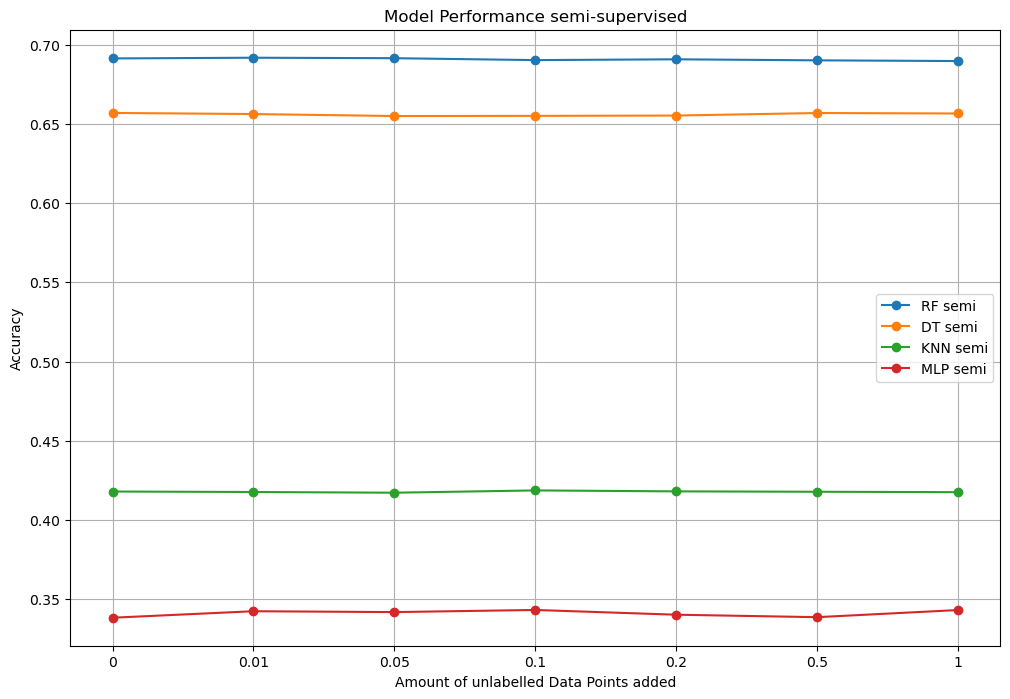

In [97]:
# visualisation for the semi-supervised learning result

plt.figure(figsize=(12, 8))

space = [7,6,5,4,3,2,1]

plt.plot(space, rf_semi_accuracy, marker='o', linestyle='-', label='RF semi')
plt.plot(space, dt_semi_accuracy, marker='o', linestyle='-', label='DT semi')
plt.plot(space, knn_semi_accuracy, marker='o', linestyle='-', label='KNN semi')
plt.plot(space, mlp_semi_accuracy, marker='o', linestyle='-', label='MLP semi')

plt.title('Model Performance semi-supervised')
plt.xlabel('Amount of unlabelled Data Points added')
plt.ylabel('Accuracy')

plt.xticks(space, labels=[str(interval) for interval in [0,0.01,0.05,0.1,0.2,0.5,1]])

plt.gca().invert_xaxis()

plt.legend()
plt.grid(True)

plt.show()